In [77]:
import pandas as pd
import glob
import json
import seaborn as sns
import tarfile
import numpy as np
import shutil
import matplotlib.pyplot as plt
from scipy.optimize import curve_fit

In [20]:
# decompress 'data.tar'gz'

with tarfile.open("data_finalized.tar.gz", "r:gz") as tar:
    tar.extractall()

paths = glob.glob('data/**/paths.json', recursive=True)
properties = glob.glob('data/**/properties.json', recursive=True)

df_paths = pd.DataFrame([json.load(open(file)) for file in paths])
df_properties = pd.DataFrame([json.load(open(file)) for file in properties])

# remove data folder

# shutil.rmtree('data')

In [72]:
df = pd.merge(df_paths, df_properties, on='name')

df["path_count"] = df["paths"].apply(lambda x: len(x))
df["pairablepath_count"] = df["pathsdetailed"].apply(lambda x: len([y for y in x if y["pairable"]]))
df["unpairablepath_count"] = df["pathsdetailed"].apply(lambda x: len([y for y in x if not y["pairable"]]))
df["min_permanent"] = df["pathsdetailed"].apply(lambda x: min([y["permanent"] for y in x]))
df["max_permanent"] = df["pathsdetailed"].apply(lambda x: max([y["permanent"] for y in x]))

In [50]:
df.query("name == 'junction_99025633'")

,name,nodes,edges,pairable,determinant,permanent,pathsdetailed,paths,conductance,i,j,sites,path_count,pairablepath_count,unpairablepath_count,min_permanent,max_permanent
945,junction_99025633,22,26,True,-169,-1,"[{'path': [23, 9, 20, 6, 17, 3, 16, 2, 15, 1],...","[{'length': 10, 'pairable': 1, 'unpairable': 4...",0.023391,11,14,"[{'index': 0, 'x': 7.5, 'y': -0.86602540378443...",6,13,19,-inf,0.0


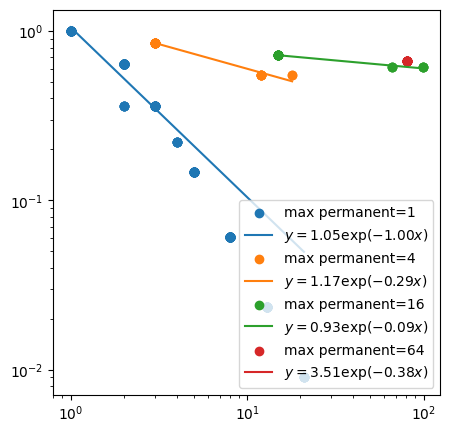

In [103]:
def f(x, a, b):
    # c = 1 - a
    # return a * np.exp(-b * x) + (1 - a)
    return a * x**(-b)

fig, ax = plt.subplots(figsize=(5, 5))
for max_permanent in [1, 4, 16, 64]:
    df_temp = df.query("max_permanent == @max_permanent")
    x = df_temp["pairablepath_count"].values
    y = df_temp["conductance"].values
    ax.scatter(x, y, label=f"max permanent={max_permanent}")
    popt, pcov = curve_fit(f, x, y)
    X = np.linspace(x.min(), x.max(), 100)
    Y = f(X, *popt)
    ax.plot(X, Y, label=f"$y={popt[0]:.2f}\\exp(-{popt[1]:.2f}x)$")
    
ax.legend(loc='lower right')

ax.set_xscale('log')
ax.set_yscale('log')

In [64]:
type(data)

matplotlib.axes._axes.Axes

In [70]:
x

array([], dtype=int64)